In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from shapely.geometry import LineString
from stl import mesh

# Plot image and load calibration parameter

Text(0.5, 1.0, 'undistorted image')

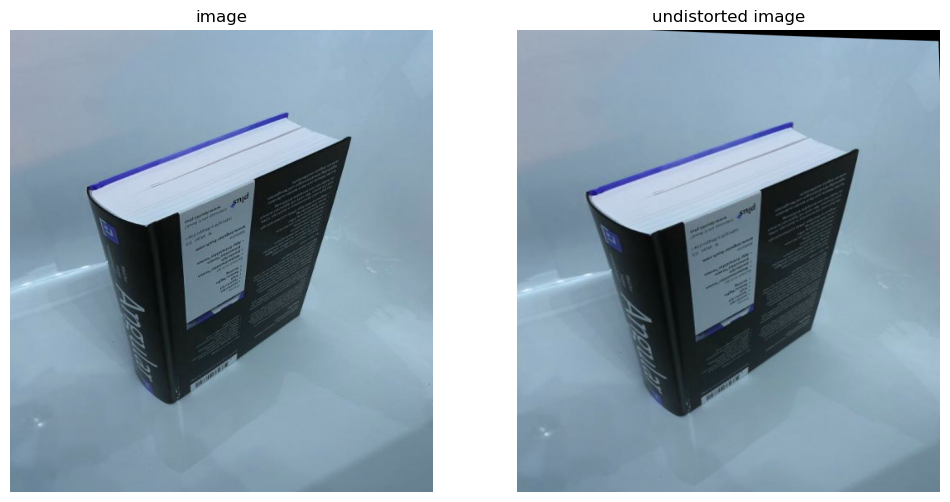

In [48]:
object_points, image_points, ret, k_matrix, distortion, r_vecs, t_vecs = np.load(
    "Calibration/cam_parameters_iPhone8.npy", allow_pickle=True)

# Load the image and undistort it using the calibration parameters
imageName = 'images/book.JPG'
image = cv2.imread(imageName)
undistorted_image = cv2.undistort(image, k_matrix, distortion)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[0].imshow(image, aspect='auto')
axs[1].imshow(undistorted_image, aspect="auto")
axs[0].set_title("image")
axs[1].set_title("undistorted image")

Text(0.5, 1.0, 'vanishing lines')

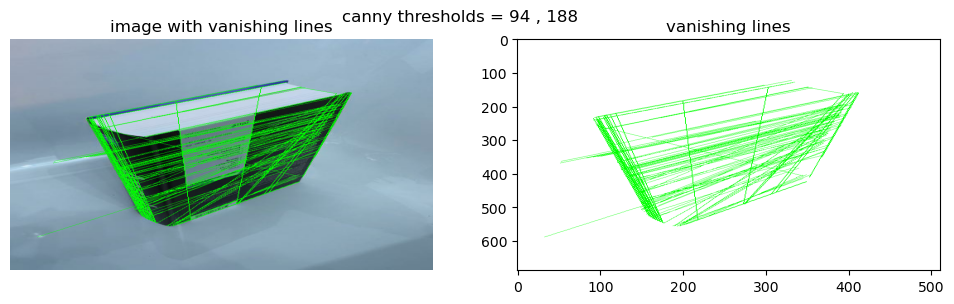

In [50]:
imageWithEdges = undistorted_image
gray = cv2.cvtColor(imageWithEdges, cv2.COLOR_RGB2GRAY)
#find optimum parameters for canny (edge detection)
v = np.mean(gray)
sigma = 0.33
cannyTh1 = int(max(0, (1.0 - sigma) * v))
cannyTh2 = int(min(255, (1.0 + sigma) * v))
edges = cv2.Canny(gray, cannyTh1, cannyTh2)

lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 30, maxLineGap=2500)
whiteImage = np.full((imageWithEdges.shape[0], imageWithEdges.shape[1], imageWithEdges.shape[2]), 255, dtype=np.uint8)

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(imageWithEdges, (x1, y1), (x2, y2), (0, 255, 0), 1)
    cv2.line(whiteImage, (x1, y1), (x2, y2), (0, 255, 0), 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
fig.suptitle("canny thresholds = " + str(cannyTh1) + " , " + str(cannyTh2))
axs[0].set_axis_off()
axs[0].imshow(imageWithEdges, aspect='auto')
axs[1].imshow(whiteImage, aspect="auto")
axs[0].set_title("image with vanishing lines")
axs[1].set_title("vanishing lines")

---
### Detect vanishing lines and manually add them

In [51]:
def detect_vanishing_lines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #find optimum parameters for canny (edge detection)
    v = np.mean(gray)
    sigma = 0.33
    cannyTh1 = int(max(0, (1.0 - sigma) * v))
    cannyTh2 = int(min(255, (1.0 + sigma) * v))
    edges = cv2.Canny(gray, cannyTh1, cannyTh2)

    lines = cv2.HoughLines(edges, 1, np.pi / 180.0, 120, np.array([]))
    return lines

In [52]:
def extend_line_starting_points(tuple):
    x1, y1 = tuple[0]
    x2, y2 = tuple[1]

    # Calculate the slope
    slope = (y2 - y1) / (x2 - x1)

    # Calculate the y-intercept
    y_intercept = y1 - slope * x1

    #extend the line
    x1 = x1 * -1000
    y1 = np.int32(slope * x1 + y_intercept)
    x2 = x2 * 1000
    y2 = np.int32(slope * x2 + y_intercept)

    return ((x1, y1), (x2, y2))

In [53]:
points = []


def on_mouse_click(event, x, y, flags, param):
    # if the left mouse button is clicked
    if event == cv2.EVENT_LBUTTONDOWN:
        # append the coordinates of the clicked point to the list
        points.append((x, y))


def let_user_draw_vanishing_lines_manually(lines):
    points.clear()
    print("Do you want to add a new line? (y/n)")
    if input() == 'y':
        #print the image and let the user click on the position. The user should select points which gets then appended as a tuple to lines
        # Create a window to display the image
        cv2.namedWindow('image')

        # Set the mouse callback function for the window
        cv2.setMouseCallback('image', on_mouse_click)

        while True:
            # Display the image in a new window
            cv2.imshow('image', imageWithEdgesOptimized)

            # Check if the user pressed the 'q' key or already 2 points selected
            if cv2.waitKey(1) & 0xFF == ord('q') or len(points) == 2:
                break

        # Destroy the window and exit the program
        cv2.destroyAllWindows()

        x1, y1 = points[0]
        x2, y2 = points[1]

        temp = imageWithEdgesOptimized.copy()
        #let user check if he/she wants to keep the line
        cv2.line(temp, (x1, y1), (x2, y2), (0, 255, 0), 1)
        plt.imshow(temp)
        #wait 2 seconds
        plt.pause(2)
        plt.close()
        print("Do you want to keep this line? (y/n)")
        if input() == 'y':
            ((x1, y1), (x2, y2)) = extend_line_starting_points(((x1, y1), (x2, y2)))
            cv2.line(imageWithEdgesOptimized, (x1, y1), (x2, y2), (0, 255, 0), 1)
            print("To which axis does the line correspond? (x/y/z)")
            answer = input()
            if answer == 'x':
                lines['x'].append(((x1, y1), (x2, y2)))
            if answer == 'y':
                lines['y'].append(((x1, y1), (x2, y2)))
            if answer == 'z':
                lines['z'].append(((x1, y1), (x2, y2)))
        return True
    else:
        return False

Do you want to add a new line? (y/n)


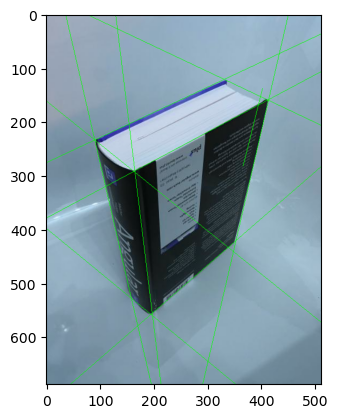

Do you want to keep this line? (y/n)
Do you want to add a new line? (y/n)


Text(0.5, 1.0, 'image with optimized vanishing lines')

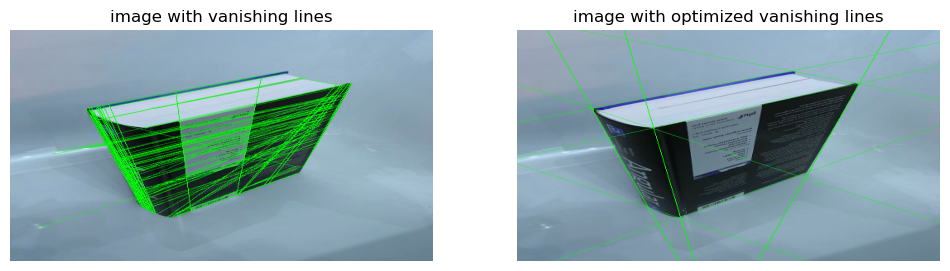

In [121]:
image = cv2.imread(imageName)
lines = detect_vanishing_lines(image)
imageWithEdgesOptimized = image.copy()

#declare an axis dictionary to store the start and end points of the lines
lineStartEndPointsAxisMap = {'x': [], 'y': [], 'z': []}

for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 10000 * (-b))
    y1 = int(y0 + 10000 * (a))
    x2 = int(x0 - 10000 * (-b))
    y2 = int(y0 - 10000 * (a))
    temp = image.copy()
    #let user check if he/she wants to keep the line
    cv2.line(temp, (x1, y1), (x2, y2), (0, 255, 0), 1)
    plt.imshow(temp)
    #wait 1 second
    plt.pause(1)
    plt.close()
    print("Do you want to keep this line? (y/n)")
    if input() == 'y':
        cv2.line(imageWithEdgesOptimized, (x1, y1), (x2, y2), (0, 255, 0), 1)
        print("To which axis does the line correspond? (x/y/z)")
        answer = input()
        if answer == 'x':
            lineStartEndPointsAxisMap['x'].append(((x1, y1), (x2, y2)))
        if answer == 'y':
            lineStartEndPointsAxisMap['y'].append(((x1, y1), (x2, y2)))
        if answer == 'z':
            lineStartEndPointsAxisMap['z'].append(((x1, y1), (x2, y2)))

while let_user_draw_vanishing_lines_manually(lineStartEndPointsAxisMap):
    pass

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[0].imshow(imageWithEdges, aspect='auto')
axs[1].imshow(imageWithEdgesOptimized, aspect="auto")
axs[0].set_title("image with vanishing lines")
axs[1].set_title("image with optimized vanishing lines")

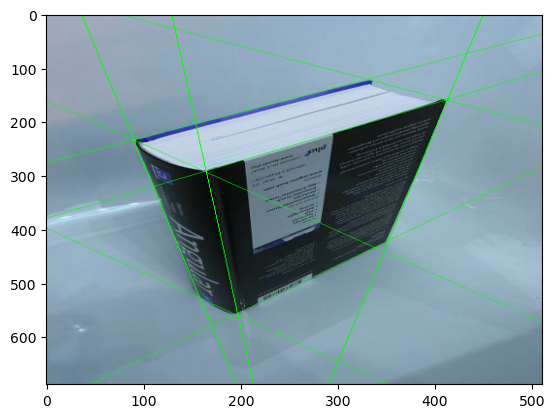

In [61]:
extendedLines = image.copy()

for key, element in lineStartEndPointsAxisMap.items():
    for e in element:
        cv2.line(extendedLines, e[0], e[1], (0, 255, 0), 1)

plt.imshow(extendedLines, aspect="auto")

### Determine Vanishing Points

In [56]:
vanishingPoints = {'x': (), 'y': (), 'z': ()}

for key, element in lineStartEndPointsAxisMap.items():
    #calculate the intersection of the first 2 lines (the others should also intersect at the same point)
    t1 = element[0]
    t2 = element[1]
    #create two lines
    line1 = LineString(t1)
    line2 = LineString(t2)
    vanishingPoints[key] = line1.intersection(line2).x, line1.intersection(line2).y

print('calculated vanishing points:')
print(vanishingPoints)

calculated vanishing points:
{'x': (-13191.531197006025, -10465.629115256419), 'y': (1571.6729645305709, -457.12083990332997), 'z': (243.29653862930746, 894.37135431985)}


---
#### Try to automatically transform the objects planes

In [68]:
#Algorithm from https://kusemanohar.wordpress.com/2014/03/18/3d-reconstruction-with-single-view/

#form the projection matrix
vx = np.array([vanishingPoints['x'][0], vanishingPoints['x'][1], 1])
vy = np.array([vanishingPoints['y'][0], vanishingPoints['y'][1], 1])
vz = np.array([vanishingPoints['z'][0], vanishingPoints['z'][1], 1])
w = np.array([0, 0, 1])

In [117]:
# World Origin in im-cords
WO = np.array([55, 195, 1])
# Reference axis-cords in im-cords
ref_x = np.array([529, 159, 1])
ref_y = np.array([423, 351, 1])
ref_z = np.array([293, 165, 1])
# Reference axis distances in pixels
ref_x_dis = 46
ref_y_dis = 205
ref_z_dis = 266
# Scaling factors of the projection matrix using the least squares solution
a_x = np.linalg.lstsq(vx.reshape(-1, 1), (ref_x - WO), rcond=None)[0] / ref_x_dis
a_y = np.linalg.lstsq(vy.reshape(-1, 1), (ref_y - WO), rcond=None)[0] / ref_y_dis
a_z = np.linalg.lstsq(vz.reshape(-1, 1), (ref_z - WO), rcond=None)[0] / ref_z_dis
# Construction of Projection Matrix
projectionMatrix = np.column_stack([vx * a_x, vy * a_y, vz * a_z, WO])

print(projectionMatrix)

[[ 4.92282698e+00  1.03303229e+00  1.21809531e-01  5.50000000e+01]
 [ 3.90557250e+00 -3.00457282e-01  4.47778483e-01  1.95000000e+02]
 [-3.73180862e-04  6.57281960e-04  5.00662819e-04  1.00000000e+00]]


Text(0.5, 1.0, 'Try to map image to xy-plane')

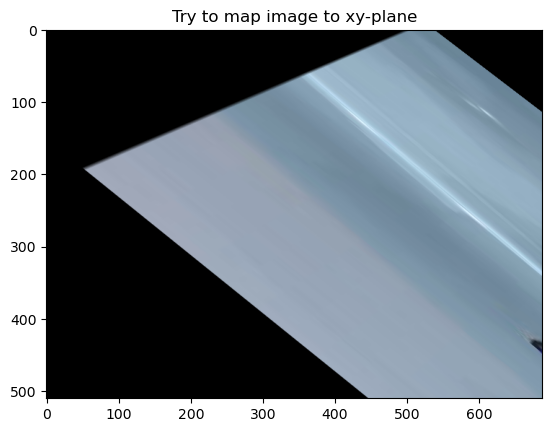

In [184]:
# transform the image to the objects  normal planes using the projection matrix
temp = projectionMatrix[:, [0, 1, 3]]
new_Image = cv2.warpPerspective(image, temp, image.shape[:2])

plt.imshow(new_Image, cmap='gray')
plt.title('Try to map image to xy-plane')

As we can see this approach was not successful, so let's determine the edges and transform the planes to rectangular images manually.

---
### Manually transform object in the image to its planes

In [120]:
#calculate the edge lengths of the object
z_length = np.ceil(np.linalg.norm(np.array([195, 557]) - np.array([165, 293])))
# x, y ,z from measurement of the real object
ratios = [0.204, 0.714, 1]
y_length = z_length * ratios[1]
x_length = z_length * ratios[0]
print(x_length)
print(y_length)
print(z_length)

54.263999999999996
189.92399999999998
266.0


### Transform and plot the YZ plane

True

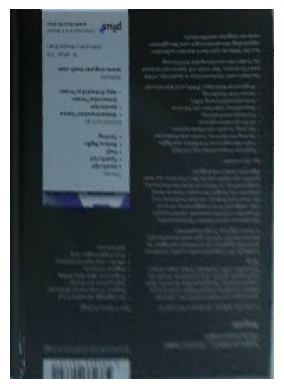

In [181]:
trans = image.copy()
#source coordinates (edges in the image)
src = np.array([165, 293,
                413, 161,
                351, 423,
                195, 557, ]).reshape((4, 2))
#destination coordinates (rectangular shape of the corresponding plane, manually calculated from the lengths)
dst = np.array([165, 161,
                355, 161,
                355, 427,
                165, 427]).reshape((4, 2))
#using skimage’s transform module where ‘projective’ is our desired parameter
tform = transform.estimate_transform('projective', src, dst)
tf_img = transform.warp(trans, tform.inverse)

yz_plane = tf_img[161:427, 165:355]

plt.imshow(yz_plane)
plt.axis(False)
cv2.imwrite('object_images/yz_plane.png', 255 * yz_plane)

### Transform and plot the XY plane

True

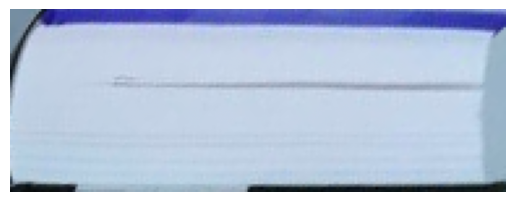

In [182]:
trans = image.copy()
#source coordinates (edges in the image)
src = np.array([91, 253,
                329, 123,
                413, 161,
                165, 293, ]).reshape((4, 2))
#destination coordinates (rectangular shape of the corresponding plane, manually calculated from the lengths)
dst = np.array([91, 123,
                281, 110,
                281, 180,
                91, 178, ]).reshape(
    (4, 2))
#using skimage’s transform module where ‘projective’ is our desired parameter
tform = transform.estimate_transform('projective', src, dst)
tf_img = transform.warp(trans, tform.inverse)

xy_plane = tf_img[110:180, 91:281]

plt.imshow(xy_plane)
plt.axis(False)
cv2.imwrite('object_images/xy_plane.png', 255 * xy_plane)

### Transform and plot the XZ plane

True

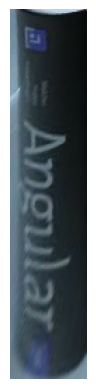

In [180]:
trans = image.copy()
#source coordinates (edges in the image)
src = np.array([91, 253,
                165, 293,
                195, 557,
                159, 529, ]).reshape((4, 2))
#destination coordinates (rectangular shape of the corresponding plane, manually calculated from the lengths)
dst = np.array([91, 255,
                146, 253,
                146, 500,
                100, 519, ]).reshape(
    (4, 2))
#using skimage’s transform module where ‘projective’ is our desired parameter
tform = transform.estimate_transform('projective', src, dst)
tf_img = transform.warp(trans, tform.inverse)

xz_plane = tf_img[253:519, 91:146]

plt.imshow(xz_plane)
plt.axis(False)
cv2.imwrite('object_images/xz_plane.png', 255 * xz_plane)

### Form a stl object with the corresponding plane pixel values

In [0]:
# Define the 8 vertices of the cube, corresponding to the ratios of the real object
vertices = np.array([
    [-1, -1, -1],
    [+55, -1, -1],
    [+55, +190, -1],
    [-1, +190, -1],
    [-1, -1, +266],
    [+55, -1, +266],
    [+55, +190, +266],
    [-1, +190, +266]])
# Define the 12 triangles composing the cube
faces = np.array([
    [0, 3, 1],
    [1, 3, 2],
    [0, 4, 7],
    [0, 7, 3],
    [4, 5, 6],
    [4, 6, 7],
    [5, 1, 2],
    [5, 2, 6],
    [2, 3, 6],
    [3, 7, 6],
    [0, 1, 5],
    [0, 5, 4]])

# Create the mesh
cube = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
for i, f in enumerate(faces):
    for j in range(3):
        cube.vectors[i][j] = vertices[f[j], :]

# Write the mesh to file "cube.stl"
cube.save('cube.stl')

### Demonstrate distortion of view mapping if object on another object

In [2]:
def on_mouse_click(event, x, y, flags, param):
    # if the left mouse button is clicked
    if event == cv2.EVENT_LBUTTONDOWN:
        # append the coordinates of the clicked point to the list
        points.append((x, y))

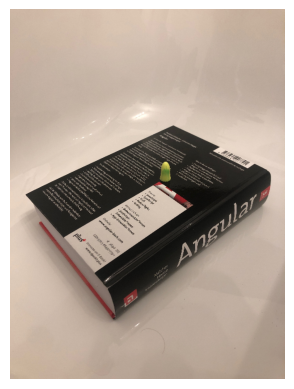

In [9]:
#again just let the user determine the vanishing lines manually
imageName = 'images/book_plug.png'
image = cv2.imread(imageName)
image = cv2.resize(image, (511, 688))
trans = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(trans)
plt.axis(False)
plt.show()

#declare an axis dictionary to store the start and end points of the lines
dummyAxisMap = {'x': [], 'y': [], 'z': []}
points = []

#just a loop to determine the points of xy-plane
# Create a window to display the image
cv2.namedWindow('image')

# Set the mouse callback function for the window
cv2.setMouseCallback('image', on_mouse_click)

while True:
    # Display the image in a new window
    cv2.imshow('image', image)

    # Check if the user pressed the 'q' key or already 2 points selected
    if cv2.waitKey(1) & 0xFF == ord('q') or len(points) == 2:
        break

# Destroy the window and exit the program
cv2.destroyAllWindows()

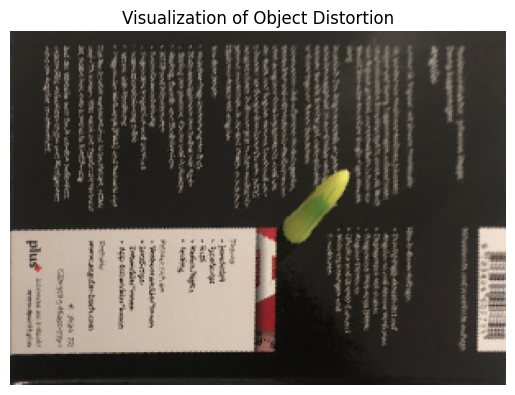

In [7]:
trans = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#source coordinates (edges in the image)
#y:len = 303 pixels and x_len according to ratio is 216 pixel
src = np.array([30, 345,
                304, 217,
                474, 297,
                174, 509, ]).reshape((4, 2))
#destination coordinates (rectangular shape of the corresponding plane, manually calculated from the lengths)
dst = np.array([30, 217,
                333, 217,
                333, 433,
                30, 433, ]).reshape(
    (4, 2))
#using skimage’s transform module where ‘projective’ is our desired parameter
tform = transform.estimate_transform('projective', src, dst)
tf_img = transform.warp(trans, tform.inverse)

xy_plane = tf_img[217:433, 30:333]

plt.imshow(xy_plane)
plt.axis(False)
plt.title('Visualization of Object Distortion')
plt.show()